# softmax

softmax函数，又称归一化指数函数。它是二分类函数sigmoid在多分类上的推广，目的是将多分类的结果以概率的形式展现出来。

![softmax计算过程](https://pic.rmb.bdstatic.com/bjh/038cfae72c79f924c0d1557641410457.png)

为什么softmax是这种形式的？

首先，我们知道概率有两个性质：
1. 预测的概率为非负数
2. 各种预测结果概率之和等于1

softmax就是将在负无穷到正无穷上的预测结果按照这两步转换为概率的。

## 将预测结果转化为非负数
下图为y=exp(x）的图像，我们可以知道指数函数的值域取值范围是零到正无穷。**softmax第一步就是将模型的预测结果转化到指数函数上，这样保证了概率的非负性**。


![image.png](https://pic.rmb.bdstatic.com/bjh/6cc3d4b9d10281c05ebb05ff44d528e0.png)

## 各种预测结果概率之和等于1

为了确保各个预测结果的概率之和等于1。我们只需要将转换后的结果进行归一化处理。

方法就是**将转化后的结果除以所有转化后结果之和，可以理解为转化后结果占总数的百分比**。这样就得到近似的概率。

### 举例说明

假如模型对一个三分类问题的预测结果为-3、1.5、2.7。我们要用softmax将模型结果转为概率。步骤如下：

1）将预测结果转化为非负数

y1 = exp(x1) = exp(-3) = 0.05

y2 = exp(x2) = exp(1.5) = 4.48

y3 = exp(x3) = exp(2.7) = 14.88



exp() 方法返回x的指数, $e^x$

In [ ]:
import math
print(math.exp(-3))
print(math.exp(1.5))
print(math.exp(2.7))

2）各种预测结果概率之和等于1

$z1 = y1 / (y1+y2+y3) = 0.05 / (0.05+4.48+14.88) = 0.0026$

$z2 = y2 / (y1+y2+y3) = 4.48 / (0.05+4.48+14.88) = 0.2308$

$z3 = y3 / (y1+y2+y3) = 14.88 / (0.05+4.48+14.88) = 0.7666$

总结一下softmax如何将多分类输出转换为概率，可以分为两步：

1）分子：通过指数函数，将实数输出映射到零到正无穷。

2）分母：将所有结果相加，进行归一化。


下图为斯坦福大学CS224n课程中对softmax的解释：
![image.png](https://pic.rmb.bdstatic.com/bjh/96fb7955458cdf44a90ec3571c822426.png)

# 数据读取

In [ ]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [ ]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

len(mnist_train), len(mnist_test)

In [ ]:
# 1表示rgb通道数为1，也就是黑白图片
mnist_train[0][0].shape

In [ ]:
# 定义两个可视化函数
def get_fashion_mnist_labels(labels):
    """
        返回Fashion-MNIST数据集的文本标签
    """
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]


In [ ]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """
        Plot a list of images
    """
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

In [ ]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y))

In [ ]:
batch_size = 256
def get_dataloader_workers():
    '''
        使用4个进程来读取的数据
    '''
    return 4

# 训练时要打乱，测试时不一定
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

timer = d2l.Timer()
for X, y in train_iter:
    continue

f'{timer.stop():.2f} sec'

In [ ]:
# 整合所有代码
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中。"""
    trans = [transforms.ToTensor()]
    # 改变图片大小
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

#  softmax回归的从零开始实现¶

In [1]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

/Users/baikal/miniforge3/envs/pytorch/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


- 对于softmax回归来说，输入需要是一个向量，所以将输入数据拉长成向量，但是会损失两个重要的信息。

和之前线性回归的例子一样，这里的每个样本都将用固定长度的向量表示。原始数据集中的每个样本都是$28 \times 28$的图像。在本节中，我们将展平每个图像，把它们看作长度为784的向量。在后面的章节中，将讨论能够利用图像空间结构的更为复杂的策略，但现在我们暂时只把每个像素位置看作一个特征。

回想一下，在softmax回归中，我们的输出与类别一样多。因为我们的数据集有10个类别，所以网络输出维度为10。

因此，权重将构成一个$784 \times 10 $的矩阵，偏置将构成一个$1 \times 10$的行向量。与线性回归一样，我们将使用正态分布初始化我们的权重W，偏置初始化为0。

In [2]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

给定一个矩阵X，求所有元素的和

In [3]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

![image.png](https://pic.rmb.bdstatic.com/bjh/1fb6a8cfc11826ea8774fadc4214a6bc.png)

In [4]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    # 就是每一行的每i个，都除以partition中第i个元素
    return X_exp / partition  # 用到了广播机制


In [6]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0406, 0.2189, 0.0265, 0.0895, 0.6245],
         [0.1198, 0.3173, 0.0928, 0.3583, 0.1118]]),
 tensor([1.0000, 1.0000]))

虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。

## 定义模型
现在我们已经定义了softmax操作，我们可以实现softmax回归模型。下面的代码定义了输入如何通过网络映射到输出。注意，在将数据传递到我们的模型之前，我们使用reshape函数将每张原始图像展平为向量。

In [7]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

## 如何取出对应的预测值
先取出对应元素

In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

然后实现交叉熵损失函数

In [ ]:
def cross_entropy(y_hat, y):
    return -torch.log(y_hat[range(len(y_hat)), y])

In [ ]:
cross_entropy(y_hat, y)

分别是样本0、1的损失

将预测类别与真实y元素进行比较

In [ ]:
def accuracy(y_hat, y):
    """
            计算预测正确的数量
    """
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # axis=1 每一行
        y_hat = y_hat.argmax(axis=1)
    # 数据类型可能不一样，对比是否一样
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

# 找出所有预测正确的样本数，除以y的数，就是预测正确的概率
accuracy(y_hat, y) / len(y)

评估在任意模型net的准确率

In [ ]:
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval() #将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    # Accumulator是一个叠加器
    for X, y in data_iter:
        # accuracy(net(X), y)求得正确样本数
        # y.numel()求得总数
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]
# metric[0]分类正确数， metric[1]分类样本总数

accumulator实例中创建了2个变量,用于分别存储正确预测的数量和预测的总数量

In [ ]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
evaluate_accuracy(net, test_iter)

## Softmax回归的训练

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # 适配手动实现或者调用框架的情况
    
    if isinstance(net, torch.nn.Module):
        # 如果是调用框架，就开启训练模式（需要计算梯度）
        net.train()
    # 长度为3的迭代器
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        # 交叉熵损失函数
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 将梯度设为0
            updater.zero_grad()
            # 反向传输计算梯度
            l.backward()
            # 参数自更新
            updater.step()
            metric.add(
                float(l) * len(y), accuracy(y_hat, y),
                y.size().numel())
        else:
            # 如果模型是自己实现的, l就是向量
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y))
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

在展示训练函数的实现之前，我们定义一个在动画中绘制数据的实用程序类。它能够简化书中其余部分的代码。

In [ ]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

### 训练函数

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        # 在测试集上测试下精度
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
#     assert train_loss < 0.5, train_loss
#     assert train_acc <= 1 and train_acc > 0.7, train_acc
#     assert test_acc <= 1 and test_acc > 0.7, test_acc

### 小批量随机梯度下降来优化模型的损失函数

In [ ]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [ ]:
import torch
from IPython import display
from d2l import torch as d2l


batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [ ]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [ ]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

In [ ]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [ ]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

In [ ]:
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [ ]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

In [ ]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

In [ ]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量。"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [ ]:
accuracy(y_hat, y) / len(y)

In [ ]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度。"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [ ]:
class Accumulator:  #@save
    """在`n`个变量上累加。"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
evaluate_accuracy(net, test_iter)

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）。"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y),
                       y.size().numel())
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练准确率
    return metric[0] / metric[2], metric[1] / metric[2]

In [ ]:
class Animator:  #@save
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [ ]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）。"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [ ]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

In [ ]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

In [ ]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

## softmax回归简洁实现

In [9]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

softmax回归的输出层是一个全连接层。因此，为了实现我们的模型，我们只需在Sequential中添加一个带有10个输出的全连接层。同样，在这里，Sequential并不是必要的，但我们可能会形成这种习惯。因为在实现深度模型时，Sequential将无处不在。我们仍然以均值0和标准差0.01随机初始化权重。

In [11]:
'''
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
'''

net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)


Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
)

## 重新审视Softmax的实现

前面的例子中，我们计算了模型的输出，然后将此输出送入交叉熵损失。从数学上讲，这是一件完全合理的事情。然而，从计算角度来看，指数可能会造成数值稳定性问题。


回想一下，softmax函数$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$，其中$\hat y_j$是预测的概率分布。$o_j$是未归一化的预测$\mathbf{o}$的第$j$个元素。如果$o_k$中的一些数值非常大，那么$\exp(o_k)$可能大于数据类型容许的最大数字（即上溢（overflow））。这将使分母或分子变为inf（无穷大），我们最后遇到的是0、inf或nan（不是数字）的$\hat y_j$。在这些情况下，我们不能得到一个明确定义的交叉熵的返回值。

解决这个问题的一个技巧是，在继续softmax计算之前，先从所有$o_k$中减去$\max(o_k)$。你可以证明每个$o_k$按常数进行的移动不会改变softmax的返回值。在减法和归一化步骤之后，可能有些$o_j$具有较大的负值。由于精度受限，$\exp(o_j)$将有接近零的值，即下溢（underflow）。这些值可能会四舍五入为零，使$\hat y_j$为零，并且使得$\log(\hat y_j)$的值为-inf。反向传播几步后，我们可能会发现自己面对一屏幕可怕的nan结果。

尽管我们要计算指数函数，但我们最终在计算交叉熵损失时会取它们的对数。 通过将softmax和交叉熵结合在一起，可以避免反向传播过程中可能会困扰我们的数值稳定性问题。如下面的等式所示，我们避免计算$\exp(o_j)$，而可以直接使用$o_j$。因为$\log(\exp(\cdot))$被抵消了。

$$log(ŷ j)=log(exp(o_j)∑_kexp(o_k))
=log(exp(o_j))−log(∑_kexp(o_k))
=o_j−log(∑_kexp(o_k))$$

我们也希望保留传统的softmax函数，以备我们需要评估通过模型输出的概率。 但是，我们没有将softmax概率传递到损失函数中，而是在交叉熵损失函数中传递未归一化的预测，并同时计算softmax及其对数，这是一件聪明的事情“LogSumExp技巧”。

In [13]:
loss = nn.CrossEntropyLoss()

## 优化算法

In [14]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

## 训练

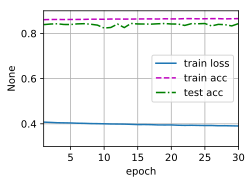

In [17]:
num_epochs = 30
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)